In [1]:
# Libraries
from collections import defaultdict
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import seaborn.apionly as sns

def getfisher(R, TISSUES):
    O=defaultdict(list)
    Mapdata = {}
    Motifs = list(set(list(R.loc[R['E.tissues']>=1]['motif'])))
    for tis in TISSUES:
        #Review motif policies here
        field= 'eSTR.'+SHORTEN[tis]
        # Focus on estrs and motifs
        data = R[["gene","chrom", "str.start","motif",field]]#,"best.score","best.tissue","INTRON"]]
        data_e = data.loc[data[field]>0]
        #motifs frequency among estrs
        Mo_counts=[list(data['motif']).count(x) for x in Motifs]
        Estr = data_e.shape[0]
        Str = data.shape[0]
        All = []
        # Fisher test for each motif
        for M in Motifs:
            data_eM = data_e.loc[data_e['motif']==M]
            data_M = data.loc[data['motif']==M]
            Mestrs = data_eM.shape[0]
            Mstrs = data_M.shape[0]
            CTT = [[Mestrs, Estr - Mestrs] , [Mstrs-Mestrs , Str-Estr -(Mstrs - Mestrs)]] #contengency
            oddsratio, pv = ss.fisher_exact([CTT[0], CTT[1]])                             #Fisher
            All.append([M,list(data_e['motif']).count(M),-np.log10(pv),oddsratio])
            O[M].append(oddsratio)
            #
        Mapdata[tis]=All
    #Selecting motifs present in all tissues
    Mset = []
    for o in O.keys():      # O has all the motifs and occurence in tissues
        if len(O[o])>=len(TISSUES):
            Mset.append(o)
    print(len(Mset))
    #heatmap matix
    pdata = np.zeros((len(TISSUES), len(Mset)))
    ODD = np.zeros((len(TISSUES), len(Mset)))
    for i in range(len(TISSUES)):
        T = TISSUES[i]
        for j in range(len(Mset)):
            m=Mset[j]
            val = [s[2] for s in  Mapdata[T] if s[0]==m ]
            odd = [s[3] for s in  Mapdata[T] if s[0]==m ]
            if val==[]:
                pdata[i][j] =0
            else:
                pdata[i][j] =val[0]
            if odd==[]:
                ODD[i][j] =0
            else:
                ODD[i][j] =odd[0]                
    return Mset,ODD,Mapdata, pdata


SHORTEN = {
    "Artery-Aorta":"Artery.A"     ,
    "Artery-Tibial": "Artery.T",
    "Adipose-Subcutaneous": "Adipose.S",    
    "Adipose-Visceral(Omentum)":"Adipose.V",
    "Brain-Caudate(basalganglia)":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "Mucosa",
    "Esophagus-Muscularis":"Muscularis",
    "Heart-LeftVentricle":"Heart",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed(Suprapubic)": "SkinUnexposed",
    "Skin-SunExposed(Lowerleg)":"SkinLeg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood"
}
#Output path
OUTPATH = "../pdfs"
PREFIX = "SupplFigure2" # Keep as a variable in case we move things around!

TISSUES = [item for item in list(SHORTEN.keys())]
regr='/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
#feat='/storage/szfeupe/Runs/GTEx_estr/FEATURES/Allgencodefeatures_table'
motif='/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed'
strand= '/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif_stranded.bed'
annotation='/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv'


/usr/lib/python3.4/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
"""Here we look at STR that fall within genes boundaries"""

#Anotation gene
ANOT = pd.read_csv(annotation, sep=',')
Genes = ANOT[['gene.chr','gene.start','gene.stop']].copy()
Genes.to_csv('genes.bed', sep='\t',index=None, header=None)

#Only work with STR in gene boundary
regression = pd.read_csv(regr, sep='\t')   
regr_subset = regression[["chrom","str.start",'str.end','str.id',"gene","E.tissues", "motif" ]]
regr_subset.to_csv('reg.bed', sep='\t',index=None, header=None)

#Intersect regression and features [within gene boundaries]
command = "bedtools intersect -a reg.bed -b genes.bed -wb -names Gene >Intersect.bed"
returned_value = os.system(command)
#OUT
inner = pd.read_csv('Intersect.bed', sep='\t', header=None)
inner.columns=["chrom","str.start",'str.end','str.id',"gene","E.tissues","motif",'chrom_x','gene.start','gene.end']    

#Subselect motifs and position 
data = inner[['chrom','str.start','str.end','gene','str.id',"E.tissues","motif"]].copy()
data1 = pd.merge(data, regression, on=list(data.columns), how='inner')
print(data.shape, data1.shape)

(185753, 7) (185546, 77)


In [3]:
#Non strand annotated
Mset,ODD,Mapdata,pdata = getfisher(data1,TISSUES)
#clustered heatmap by correlation
df1 = pd.DataFrame(ODD)
df1.index = [SHORTEN[t] for t in TISSUES]
df1.columns = Mset; print(df1.shape)
'''
metric="correlation"
Motifs present in heatmap are those observed across tissues  VV
'''
motifs = sorted([x for x in df1.columns if x  in Mset]) ; len(motifs)

165
(17, 165)


165

In [4]:
"""Order it?"""
df = df1[motifs].copy()
df.loc['Total']= df.sum()
df = df.sort_values(by='Total', axis=1)
df = df.drop(['Total'])
#plot Enrichrment of motifs at eSTRs..

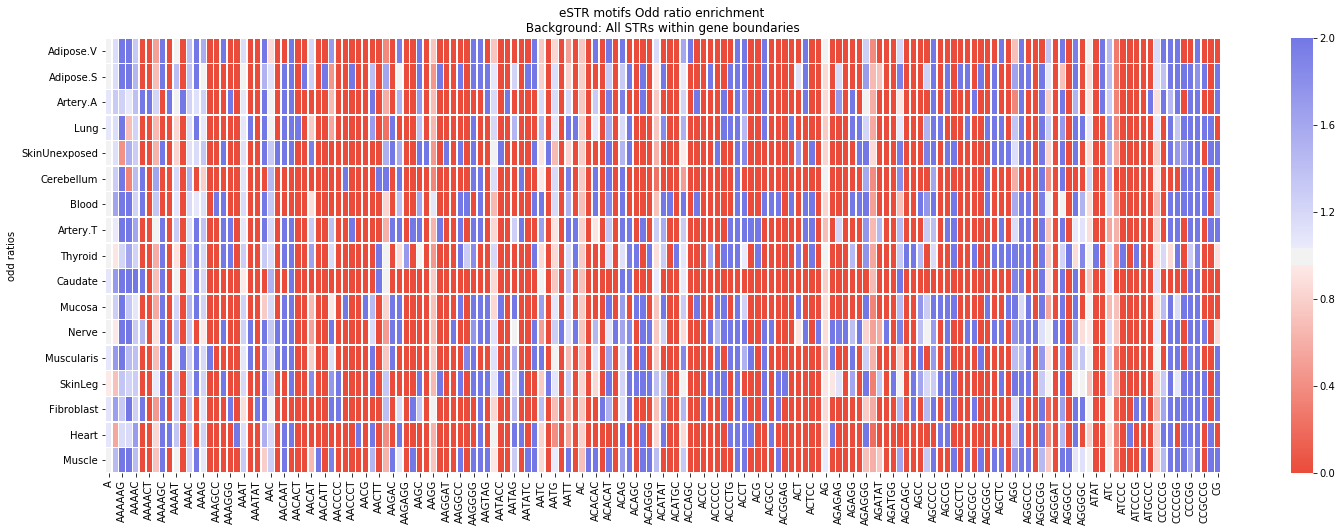

In [5]:
#plot Motifs Enrichrment 
df1 = df1[motifs]
fig, ax = plt.subplots(figsize=(25, 8))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
g = sns.heatmap(df1, cmap=cmap, annot_kws={"size": 8},
            vmin=0, vmax=2, linewidths=0.5   );
plt.ylabel("odd ratios")
plt.title('eSTR motifs Odd ratio enrichment \n Background: All STRs within gene boundaries ')
fig.savefig(os.path.join(OUTPATH, "%s_estr_motifenrichment_vs_allSTRs_odds.pdf"%PREFIX))
plt.show()

(17, 165)


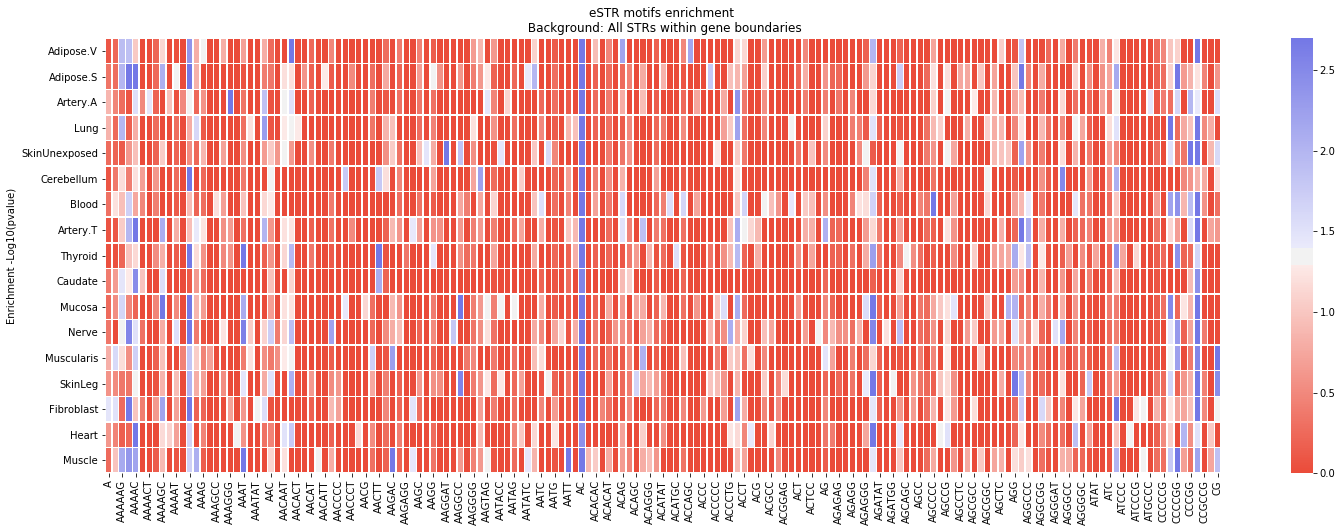

In [6]:
df2 = pd.DataFrame(pdata)
df2.index = [SHORTEN[t] for t in TISSUES]
df2.columns = Mset; print(df2.shape)

df2 = df2[motifs]
fig, ax = plt.subplots(figsize=(25, 8))
cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
g = sns.heatmap(df2, cmap=cmap, annot_kws={"size": 8},
            vmin=0, vmax=2.7, linewidths=0.5   );
plt.ylabel("Enrichment -Log10(pvalue)")
plt.title('eSTR motifs enrichment \n Background: All STRs within gene boundaries')
fig.savefig(os.path.join(OUTPATH, "%s_estr_motifenrichment_vs_allSTRs_pval.pdf"%PREFIX))
plt.show()

In [6]:
df1      #odd ratio

,A,AAAAAC,AAAAAG,AAAAAT,AAAAC,AAAACC,AAAACT,AAAAG,AAAAGC,AAAAGG,...,C,CCCCCG,CCCCG,CCCCGG,CCCG,CCCGG,CCG,CCGCCG,CCGCG,CG
Nerve,0.970467,0.948645,2.138639,2.171040,1.295856,1.491366,0.000000,0.904146,6.264837,0.000000,...,1.042464,0.000000,3.388699,4.899680,0.000000,2.557408,2.521253,1.957526,0.000000,0.857901
Adipose.V,1.015130,1.155845,3.268784,2.472423,1.331991,0.000000,0.000000,0.517041,14.509055,0.000000,...,1.156318,2.637366,3.819813,4.333133,0.000000,0.000000,3.132497,0.000000,0.000000,0.000000
Mucosa,0.974168,1.267445,2.383772,1.339508,1.074686,0.000000,0.000000,0.564159,29.588663,0.000000,...,0.898726,1.433000,5.407062,1.158961,3.585369,3.218428,2.428642,0.000000,0.000000,0.000000
Caudate,1.083777,1.721880,4.341085,2.923095,2.063932,9.274586,0.000000,0.692406,38.960000,0.000000,...,1.101240,0.000000,0.000000,0.000000,0.000000,7.790316,4.168819,0.000000,0.000000,0.000000
Muscle,0.973629,1.439211,2.744671,2.307502,1.427014,0.000000,0.000000,0.720289,8.033932,0.000000,...,0.822748,1.460356,4.346867,6.285683,2.398494,1.606436,2.174315,0.000000,5.355809,4.595359
Heart,1.072243,0.550519,1.156304,1.171747,1.701288,0.000000,0.000000,0.840254,15.676786,13.063846,...,0.798109,2.849629,4.127503,0.000000,7.135783,3.134677,2.234224,0.000000,10.450907,0.000000
Thyroid,1.005812,0.934254,1.224272,1.624191,1.249717,0.000000,0.000000,0.588125,6.561939,0.000000,...,0.899816,1.192786,0.851887,5.132371,0.000000,1.312101,1.896302,0.000000,0.000000,0.898586
Muscularis,1.069517,1.719568,2.156198,1.445018,1.391861,0.000000,0.000000,0.686010,9.583455,0.000000,...,1.038606,0.000000,3.836029,5.904990,0.000000,1.916273,2.417998,0.000000,0.000000,8.475436
Blood,1.034791,1.619749,1.989818,2.226579,1.230336,2.536618,0.000000,1.344648,0.000000,0.000000,...,0.663104,0.000000,5.767838,6.566783,3.181650,6.666135,3.899316,3.329493,0.000000,1.459178
Adipose.S,0.967809,1.155374,2.603122,2.491577,1.478810,0.000000,0.000000,0.683203,16.942640,0.000000,...,1.091134,1.385291,3.049846,7.271099,2.275156,3.111234,1.779067,2.381268,0.000000,2.117101


In [7]:
df2  #log10(pvalues)

,A,AAAAAC,AAAAAG,AAAAAT,AAAAC,AAAACC,AAAACT,AAAAG,AAAAGC,AAAAGG,...,C,CCCCCG,CCCCG,CCCCGG,CCCG,CCCGG,CCG,CCGCCG,CCGCG,CG
Nerve,0.351655,-0.000000,1.363737,2.549566,1.511661,0.306271,-0.000000,-0.000000,0.796113,-0.000000,...,0.111577,-0.000000,1.458986,2.330289,0.200221,0.718600,3.850540,0.390264,-0.000000,-0.000000
Adipose.V,0.099318,0.230682,1.923103,1.883070,1.025891,-0.000000,-0.000000,0.220981,1.137725,-0.000000,...,0.251254,0.495480,0.998940,1.089050,-0.000000,-0.000000,3.154221,-0.000000,-0.000000,-0.000000
Mucosa,0.259639,0.543876,1.639817,0.478842,0.215558,-0.000000,-0.000000,0.469441,3.521847,-0.000000,...,0.126638,0.295412,2.515814,0.235715,1.251874,0.872478,2.963106,-0.000000,-0.000000,-0.000000
Caudate,0.399937,0.649413,1.470246,1.289801,2.478071,0.980536,-0.000000,-0.000000,1.555004,-0.000000,...,0.091375,-0.000000,-0.000000,-0.000000,-0.000000,0.910799,2.414395,-0.000000,-0.000000,-0.000000
Muscle,0.262565,0.977487,2.140089,2.344388,2.204172,-0.000000,-0.000000,0.156002,0.895272,-0.000000,...,0.288683,0.301047,1.799633,2.784822,0.681054,0.329703,2.197825,-0.000000,0.745602,1.876344
Heart,0.613642,0.463937,0.159138,0.229388,2.708739,-0.000000,-0.000000,-0.000000,1.170002,1.100177,...,0.186860,0.523140,1.054987,-0.000000,2.009766,0.557244,1.507947,-0.000000,1.014079,-0.000000
Thyroid,0.049991,0.044446,0.213115,0.978078,1.149699,-0.000000,-0.000000,0.528611,0.814422,-0.000000,...,0.158345,0.243021,-0.000000,2.413370,0.200932,0.269407,1.650049,-0.000000,-0.000000,-0.000000
Muscularis,0.818260,1.593576,1.181961,0.551755,1.707862,-0.000000,-0.000000,0.172308,0.966743,-0.000000,...,0.089815,-0.000000,1.324844,2.239036,-0.000000,0.385910,2.534605,-0.000000,-0.000000,3.910803
Blood,0.311060,1.219716,0.946610,1.702514,0.756218,0.480221,-0.000000,0.424383,-0.000000,-0.000000,...,0.673929,-0.000000,2.209592,2.398602,0.868786,1.920460,6.169682,0.576088,-0.000000,0.301648
Adipose.S,0.347145,0.292041,2.002168,3.077403,2.714419,-0.000000,-0.000000,0.242947,2.068582,-0.000000,...,0.172726,0.285430,1.091429,3.551566,0.647719,0.849214,1.229393,0.456248,-0.000000,0.603854


In [ ]:
"""
#Subselect motifs and position 

#Strand maybe?
strands = pd.read_csv(strand, sep='\t', header=None)
strands.columns =['chrom','str.start','end','motiflength', 'For_motif','Rev_motif']
st_data = pd.merge(data1, strands[['chrom','str.start','For_motif','Rev_motif']], on=['chrom','str.start'], how='inner')
#annotation
annot = pd.read_csv(annotation, sep=',')
annot['gene']=annot['gene.id']               
annot['chrom'] = annot['gene.chr']
st_data = pd.merge(st_data, annot[['chrom','gene', 'gene.strand']], on=['chrom','gene'])
st_data['Motif']=st_data['For_motif'].where(st_data['gene.strand'] == '+', st_data['Rev_motif']) #Strand annotation

"""